# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [1]:
!pip install seaborn
!pip install miceforest
!pip install fancyimpute
!pip install missingno
!pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib as mpl

%matplotlib inline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, Trials
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from fancyimpute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
import miceforest as mf
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

### 데이터 셋 읽어오기

In [3]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [4]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_desc_length,inquiry_type,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,NaN,purchasing,62,Quotation or purchase consultation,multi-split,NaN,NaN,/Quezon City/Philippines,entry level,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,NaN,media and communication,96,Quotation or purchase consultation,multi-split,NaN,NaN,/PH-00/Philippines,ceo/founder,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,NaN,engineering,56,Product Information,single-split,NaN,NaN,/Kolkata /India,partner,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,NaN,entrepreneurship,44,Quotation or purchase consultation,vrf,NaN,NaN,/Bhubaneswar/India,ceo/founder,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,consulting,97,Quotation or purchase consultation,multi-split,NaN,NaN,/Hyderabad/India,partner,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


## 2. 데이터 전처리

In [5]:
df_train.dropna(subset=['customer_country'], inplace=True)

In [6]:
df_train['customer_country'] = df_train['customer_country'].str.upper()
df_train['City'] = df_train['customer_country'].str.split('/').str[1].str.strip()
df_train['Country'] = df_train['customer_country'].str.split('/').str[2].str.strip()
df_test['customer_country'] = df_test['customer_country'].str.upper()
df_test['City'] = df_test['customer_country'].str.split('/').str[1].str.strip()
df_test['Country'] = df_test['customer_country'].str.split('/').str[2].str.strip()

In [7]:
continent_mapping = { 'North America': ['LGEMX', 'LGERS', 'LGEAZ', 'LGEMM', 'LGESP', 'LGEAI', 'LGECI', 'LGEUS', 'LGEMU', 'LGEMS', 'LGEAR', 'LGEPS', 'LGECB', 'LGECL', 'LGEPR'],
                     'Europe': ['LGEWA', 'LGEMA', 'LGEWR', 'LGEUK', 'LGEFS', 'LGEES', 'LGEEH', 'LGEJE', 'LGEDG', 'LGEIS', 'LGEMK', 'LGEPL', 'LGESW', 'LGEHS', 'LGEAG', 'LGERO', 'LGECZ', 'LGEPT', 'LGEBN', 'LGESC', 'LGELS', 'LGENO'],
                     'Central America': ['LGEEG', 'LGEAT', 'LGESR', 'LGETK', 'LGESA', 'LGEMC', 'LGEGF', 'LGEME', 'LGEOT', 'LGEEC', 'LGENI', 'LGEAF', 'LGELF'],
                     'Asia': ['LGEIL', 'LGETH', 'LGEVN', 'LGEIN', 'LGECH', 'LGEHK', 'LGESL', 'LGEML', 'LGEJP', 'LGETT', 'LGEPH'],
                     'China': ['LGETR', 'LGEHZ', 'LGEND', 'LGEPN', 'LGEQH', 'LGESH', 'LGESY', 'LGETA', 'LGEYT', 'LGEKS', 'LGENP', 'LGEHN', 'LGEQD'],
                     'CSI Other': ['LGEAK', 'LGERA', 'LGEAP', 'LGERI', 'LGERM', 'LGEUR', 'LGELV'] }
df_train['Continent'] = ''
df_test['Continent'] = ''
for continent, values in continent_mapping.items():
    df_train.loc[df_train['response_corporate'].isin(values), 'Continent'] = continent
    df_test.loc[df_test['response_corporate'].isin(values), 'Continent'] = continent

In [8]:
df_train

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_desc_length,inquiry_type,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,City,Country,Continent
0,1.00,/QUEZON CITY/PHILIPPINES,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,NaN,purchasing,62,Quotation or purchase consultation,multi-split,NaN,NaN,/Quezon City/Philippines,entry level,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True,QUEZON CITY,PHILIPPINES,Asia
1,1.00,/PH-00/PHILIPPINES,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,NaN,media and communication,96,Quotation or purchase consultation,multi-split,NaN,NaN,/PH-00/Philippines,ceo/founder,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True,PH-00,PHILIPPINES,Asia
2,1.00,/KOLKATA /INDIA,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,NaN,engineering,56,Product Information,single-split,NaN,NaN,/Kolkata /India,partner,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True,KOLKATA,INDIA,Asia
3,1.00,/BHUBANESWAR/INDIA,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,NaN,entrepreneurship,44,Quotation or purchase consultation,vrf,NaN,NaN,/Bhubaneswar/India,ceo/founder,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True,BHUBANESWAR,INDIA,Asia
4,1.00,/HYDERABAD/INDIA,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,consulting,97,Quotation or purchase consultation,multi-split,NaN,NaN,/Hyderabad/India,partner,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True,HYDERABAD,INDIA,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,/SLĄSKIE/POLAND,AS,NaN,33747,End Customer,SMB,NaN,NaN,NaN,NaN,engineering,200,Product Information,vrf,NaN,NaN,/Sląskie/Poland,entry level,LGEPL,3 months ~ 6 months,0,0,0.000026,0.028777,public facility,Others,694,False,SLĄSKIE,POLAND,Europe
59295,0.75,/BOGOTÁ DC /COLOMBIA,AS,0.040000,35420,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,entrepreneurship,70,NaN,etc.,NaN,NaN,/Bogotá DC /Colombia,trainee,LGECB,9 months ~ 1 year,0,0,0.000026,0.028777,public facility,NaN,39,False,BOGOTÁ DC,COLOMBIA,North America
59296,0.75,/PISCO/PERU,AS,0.040000,19249,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,engineering,34,NaN,single-split,NaN,NaN,/Pisco/Peru,entry level,LGEPR,less than 3 months,0,0,0.000026,0.028777,public facility,NaN,125,False,PISCO,PERU,North America
59297,1.00,/SANTA CRUZ BOLIVIA/PERU,AS,0.040000,40327,NaN,Enterprise,NaN,NaN,NaN,NaN,entrepreneurship,377,Quotation or Purchase Consultation,etc.,NaN,NaN,/santa cruz bolivia/Peru,others,LGEPR,more than a year,0,0,0.000026,0.028777,public facility,NaN,134,False,SANTA CRUZ BOLIVIA,PERU,North America


In [9]:
df_test

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_desc_length,inquiry_type,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,City,Country,Continent
0,19844,0.00,/ / BRAZIL,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,NaN,NaN,consulting,3,NaN,NaN,NaN,NaN,/ / Brazil,none,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,0,,BRAZIL,North America
1,9738,0.25,400 N STATE OF FRANKLIN RD CLOUD IT / JOHNSON...,IT,NaN,5405,End Customer,SMB,NaN,NaN,NaN,NaN,NaN,23,Quotation or Purchase Consultation,NaN,NaN,NaN,400 N State Of Franklin Rd Cloud IT / Johnson...,none,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,1,JOHNSON CITY,UNITED STATES,North America
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,NaN,NaN,information technology,138,Quotation or Purchase Consultation,hospital tv,UT662M Series,50UT662M (MEA),/ / U.A.E,manager,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,0,,U.A.E,Central America
3,19895,0.50,/ MADISON / UNITED STATES,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,NaN,NaN,sales,3,Quotation or Purchase Consultation,NaN,Digital Signage or Commercial TVs,NaN,/ Madison / United States,none,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,0,MADISON,UNITED STATES,North America
4,10465,1.00,/ SAO PAULO / BRAZIL,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,NaN,1.0,engineering,107,Quotation or Purchase Consultation,led signage,LG LED Bloc,LSAA012,/ Sao Paulo / Brazil,others,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,0,SAO PAULO,BRAZIL,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,/SÃO PAULO/BRAZIL,AS,NaN,40292,NaN,Enterprise,10.0,NaN,NaN,NaN,sales,7,Quotation or Purchase Consultation,NaN,NaN,NaN,/São Paulo/Brazil,associate/analyst,LGESP,NaN,0,0,NaN,NaN,NaN,NaN,97,0,SÃO PAULO,BRAZIL,North America
5267,7979,0.25,GENERAL / / UNITED STATES,IT,NaN,47466,NaN,Enterprise,0.0,NaN,NaN,NaN,NaN,157,Quotation or Purchase Consultation,NaN,NaN,NaN,General / / United States,none,LGEUS,NaN,0,0,NaN,NaN,NaN,NaN,438,1,,UNITED STATES,North America
5268,12887,0.75,/ OURO BRANCO / BRAZIL,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,entrepreneurship,39,NaN,multi-split,NaN,NaN,/ OURO BRANCO / Brazil,manager,LGESP,less than 3 months,0,0,NaN,NaN,NaN,NaN,97,0,OURO BRANCO,BRAZIL,North America
5269,17530,0.00,/ / GERMANY,IT,NaN,45667,End Customer,SMB,NaN,NaN,NaN,NaN,NaN,3,NaN,cloud device,NaN,NaN,/ / Germany,none,LGEDG,NaN,0,0,NaN,NaN,NaN,NaN,429,0,,GERMANY,Europe


In [10]:
numeric_columns = df_train.select_dtypes(include='number')

columns_without_missing_values = numeric_columns.columns[numeric_columns.isnull().sum() == 0]

columns_to_exclude = ['id_strategic_ver', 'it_strategic_ver','idit_strategic_ver']
columns_to_exclude.extend(columns_without_missing_values)

columns_to_impute = numeric_columns.drop(columns=columns_to_exclude, errors='ignore')

imputer = IterativeImputer()

df_train_imputed = pd.DataFrame(imputer.fit_transform(columns_to_impute), columns=columns_to_impute.columns)

replacement_values = df_train_imputed.mean()
print("각 열의 대체값:")
print(dict(zip(columns_to_impute.columns, replacement_values)))

각 열의 대체값:
{'com_reg_ver_win_rate': 0.09308415174570663, 'historical_existing_cnt': 18.10790875959134, 'ver_win_rate_x': 0.0011278615167162956, 'ver_win_ratio_per_bu': 0.055160001729757595}


/home/elicer/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [11]:
df_train[columns_to_impute.columns] = df_train[columns_to_impute.columns].fillna(replacement_values)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58317 entries, 0 to 59298
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              58317 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            58317 non-null  object 
 3   com_reg_ver_win_rate     58317 non-null  float64
 4   customer_idx             58317 non-null  int64  
 5   customer_type            15310 non-null  object 
 6   enterprise               58317 non-null  object 
 7   historical_existing_cnt  58317 non-null  float64
 8   id_strategic_ver         3106 non-null   float64
 9   it_strategic_ver         1116 non-null   float64
 10  idit_strategic_ver       4222 non-null   float64
 11  customer_job             40133 non-null  object 
 12  lead_desc_length         58317 non-null  int64  
 13  inquiry_type             57948 non-null  object 
 14  product_category         39

In [13]:
df_train = df_train.drop(["City", "Country", "response_corporate", "id_strategic_ver", "idit_strategic_ver","it_strategic_ver","customer_country" ,"customer_country.1"], axis=1)
df_test = df_test.drop(["City","Country", "response_corporate","id_strategic_ver", "idit_strategic_ver","it_strategic_ver","customer_country" ,"customer_country.1"], axis=1)

In [14]:
def normalize_category(category):
    if pd.isna(category):  # NaN 처리
        return "NaN"
    else:
        # 소문자로 변환하고 공백 제거
        return category.lower().replace(' ', '')

# 각 범주 일반화 및 대체
df_train['customer_type'] = df_train['customer_type'].apply(normalize_category)

In [15]:
replacement_map = {
    'End Customer': ['endcustomer', 'end-customer', 'constructioncompany', 'owner/developer', 'medical/healthcarefacility', 'government/publicsectorr', 'corporate', 'education', 'retail', 'fitness', 'homeowner','developer','end-user','commercialend-user','administrator'],
    'Channel Partner': ['channelpartner', 'agent', 'distributor', 'reseller', 'nsp(usonly)', 'nationalreseller', 'regionalreseller', 'si(systemintegrator)', 'proav/avconsultant', 'var(3po)', 'systemintegrator','dealer/distributor'],
    'Solution Eco-Partner': ['solutionecopartner', 'cms/webos/isv', 'mount/metalfabrication', 'meetingsolution', 'control/processor', 'externalcompute', 'solutioneco-partner','software/solutionprovider'],
    'Service Partner': ['servicepartner', 'authorizedservicecenter', 'authorizedservicedealer', 'technician','technicalassistant'],
    'Specifier/ Influencer': ['specifier/influencer', 'architect', 'consultant', 'contractor', 'technical/designfirm', 'regionbuilder', 'installer','ad&dontentsprovider', 'appliedrep', 'installer/contractor', 'engineer','manager/director' ,'architect/consultant','hvacengineer','interiordesigner'],
    'Developer':['developer'],
    'NaN':['other','others','etc.']
    }


for new_category, old_categories in replacement_map.items():
    for old_category in old_categories:
        df_train['customer_type'].replace(old_category, new_category, inplace=True)

print(df_train['customer_type'].unique())

['End Customer' 'Specifier/ Influencer' 'Service Partner'
 'Channel Partner' 'NaN' 'Solution Eco-Partner']


### 레이블 인코딩

In [17]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [18]:
# 레이블 인코딩할 칼럼들
label_columns = [
   #"customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
   # "customer_country.1",
    "customer_position",
    #"response_corporate",
    "expected_timeline",
    "Continent",
    # "Country"
]


df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

    

다시 학습 데이터와 제출 데이터를 분리합니다.

In [19]:
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

### 2-2. 학습, 검증 데이터 분리

In [20]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,)

In [21]:
def objective_func(params):
    accuracy_list = []
    kf = KFold(n_splits=3)
    for train_index, val_index in kf.split(x_train):
        x_tr, x_val = x_train.iloc[train_index], x_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        xgb_clf = XGBClassifier(**params, random_state=400, enable_categorical=True)
        xgb_clf.fit(x_tr, y_tr)
        preds = xgb_clf.predict(x_val)
        accuracy = accuracy_score(y_val, preds)
        accuracy_list.append(accuracy)
    return -1 * np.mean(accuracy_list)  

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 300)),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
}

trials = Trials()
best = fmin(fn=objective_func,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
           )


100%|██████████| 100/100 [02:46<00:00,  1.66s/trial, best loss: -0.9723919147750412]


## 3. 모델 학습

### 모델 정의 

In [22]:
from hyperopt import space_eval

best_params = space_eval(space, best)
xgb_clf = XGBClassifier(**best_params, random_state=400)

### 모델 학습

In [23]:
xgb_clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6535844089383915, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.28063975367209143,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=177, n_jobs=None,
              num_parallel_tree=None, random_state=400, ...)

### 모델 성능 보기

In [24]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [25]:
pred = xgb_clf.predict(x_val)
get_clf_eval(y_val, pred)

오차행렬:
 [[  744   212]
 [   79 10629]]

정확도: 0.9751
정밀도: 0.9040
재현율: 0.7782
F1: 0.8364


## 4. 제출하기

### 테스트 데이터 예측

In [26]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [27]:
test_pred = xgb_clf.predict(x_test)
sum(test_pred) # True로 예측된 개수

949

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

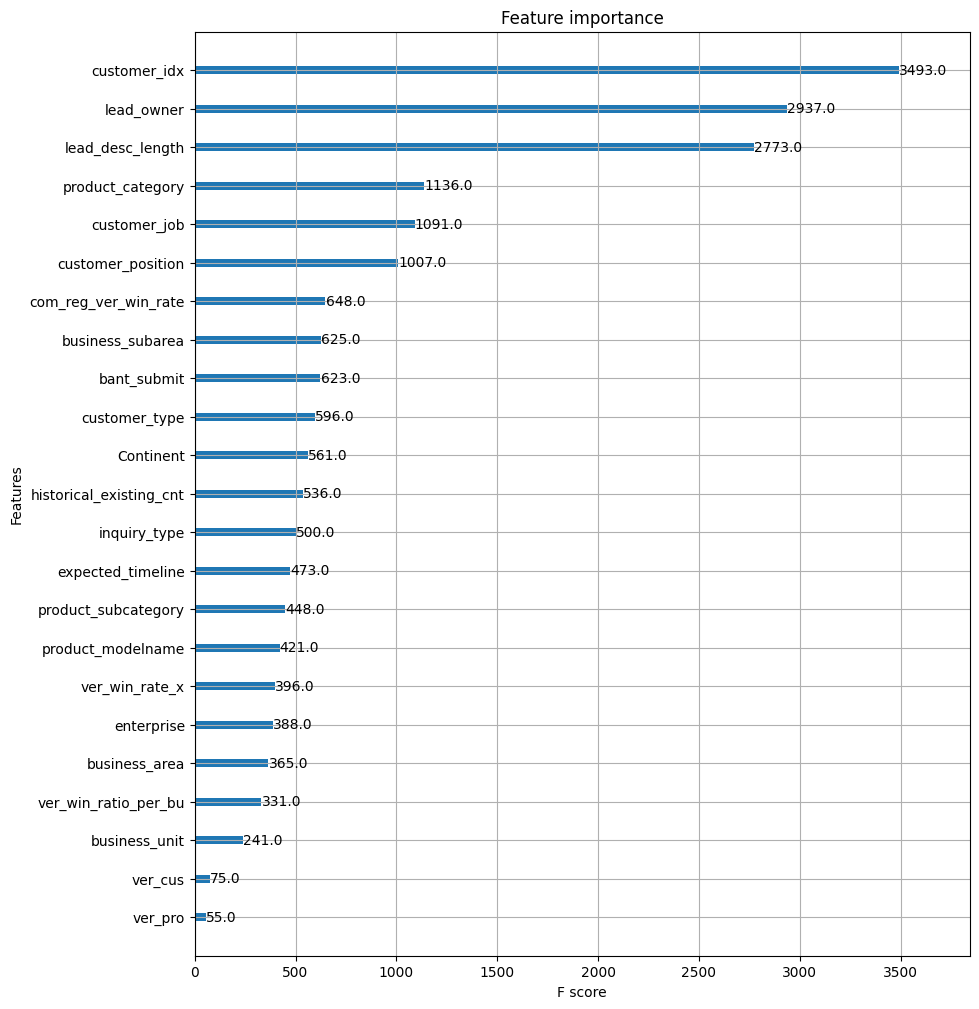

In [28]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_clf, ax=ax)

### 제출 파일 작성

In [30]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**